In [1]:
import tensorflow as tf
from common.tf_util import get_session
from common.cmd_util import make_vec_env
from common.policies import build_policy
from common.policies_aip import build_policy as build_policy_aip
from ppo2.runner import Runner
import gym, os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from ppo2.model import Model

def build_env(env_id,seed=0,goal_height=1.0,ho=0,ah_goal_loc_idx=8,ctrl_rwd=1,env_type='corl',with_obs=0,obs_idx=20,ah_with_goal_loc=0,ah_with_reach_goal=1,ctrl_rwd_coef=1):
    config = tf.ConfigProto(allow_soft_placement=True,intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    config.gpu_options.allow_growth = True
    get_session(config=config)
    env = make_vec_env(env_id, env_type, 2000, with_obs, 1, obs_idx, 1e6, 0, ah_with_goal_loc, ah_goal_loc_idx, ah_with_reach_goal, ctrl_rwd, 0, ctrl_rwd_coef, ho, goal_height, 1, seed, reward_scale=1.0, flatten_dict_observations=True)
    return env

def prepare(env_id,seed,load_path,model,goal_height=1.0,ho=0):
    env=build_env(env_id,seed=seed,goal_height=goal_height,ho=ho)
    model.load(load_path)
    runner = Runner(env=env, model=model, nsteps=2048, gamma=0.99, lam=0.95)
    return model,runner

def rollout_reacher(set_path,run_idx,plan_path,plan_action_path,big_goal_radius=0.02):
    real_env=gym.make('Reacher-v2')
    real_env.seed(1000000+run_idx)
    obs=real_env.reset()
    ro_path=np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)
    goal_loc=obs[4:6]
    initial_state=ro_path[0,-2:].copy()
    for i in range(plan_action_path.shape[0]):
        obs=real_env.step(plan_action_path[i])[0]
        ro_path=np.concatenate((ro_path,np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)),axis=0)
    fig, ax = plt.subplots(figsize=(8,8))
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    plt.scatter(initial_state[-2], initial_state[-1], s=150, marker='*', color ='k',label='start')
    plt.plot(plan_path[:,-4],plan_path[:,-3],'-k',label='Planned Path')
    plt.plot(ro_path[:,-2],ro_path[:,-1],'-r',label='Rollout Path')
    plt.xlim([-0.22, 0.22])
    plt.ylim([-0.22, 0.22])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(set_path+'Reacher-v2_run'+str(run_idx)+'_rollout.png',dpi=200)
    plt.show()
    return plan_path,ro_path

def compare_reacher(set_path,aip_pi,run_idx,plan_path,plan_action_path,big_goal_radius=0.02):
    real_env=gym.make('Reacher-v2')
    real_env.seed(1000000+run_idx)
    obs=real_env.reset()
    ro_path=np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)
    goal_loc=obs[4:6]
    initial_state=ro_path[0,-2:].copy()
    for i in range(plan_action_path.shape[0]):
        obs=real_env.step(plan_action_path[i])[0]
        ro_path=np.concatenate((ro_path,np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)),axis=0)
    
    real_env=gym.make('Reacher-v2')
    real_env.seed(1000000+run_idx)
    obs=real_env.reset()
    done=False
    aip_ro_path=np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)
    while not done:
        ac,v, state, neglogp, action_ref, alpha=aip_pi.step(obs,stochastic=True,ref_stochastic=False)
        obs,_,done,_=real_env.step(ac)
        aip_ro_path=np.concatenate((aip_ro_path,np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)),axis=0)
    fig, ax = plt.subplots(figsize=(8,8))
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    plt.text(goal_loc[0]-0.01, goal_loc[1]-0.01,str(run_idx),fontsize=20)
    plt.scatter(initial_state[-2], initial_state[-1], s=150, marker='*', color ='k',label='start')
    plt.plot(plan_path[:,-4],plan_path[:,-3],'-k',label='PPO planned path in dynamics model')
    plt.plot(ro_path[:,-2],ro_path[:,-1],'-r',label='PPO rollout path')
    plt.plot(aip_ro_path[:,-2],aip_ro_path[:,-1],'-b',label='AIP Path')
    plt.xlim([-0.22, 0.22])
    plt.ylim([-0.22, 0.22])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(set_path+'Reacher-v2_run'+str(run_idx)+'_compare.png',dpi=200)
    plt.show()

In [2]:
ho=0.999

model_fn = Model
env_id='corl_Reacher-v2'
env=build_env(env_id,0,1.0,ho=ho)
ob_space = env.observation_space
ac_space = env.action_space
policy = build_policy(env, 'mlp', value_network='copy')
model = model_fn(policy=policy, env_type='corl', ob_space=ob_space, ac_space=ac_space, nbatch_act=1, nbatch_train=64,ent_coef=0.0, vf_coef=0.5,max_grad_norm=0.5, comm=None, mpi_rank_weight=1)
#model.load('./ppo2_results/models_bkup/corl_Reacher-v2/seed_ho0.999_7')


Logging to /var/folders/h2/zl4wv27s7_l5c_09wvwjdl_80000gn/T/openai-2021-07-15-13-36-05-917385


r_diff args {'kwargs': {}, 'forward_dynamic': None, 'batch_size': 512, 'update_epochs': 5, 'make_model': <function get_make_mlp_model.<locals>._thunk at 0x15899fc80>, 'env_id': 'Reacher-v2', 'env': <ClipActionsWrapper<Monitor<TimeLimit<ReacherEnv<Reacher-v2>>>>>, 'self': <r_diff.r_diff.R_diff_model object at 0x15696e2e8>}
Forward dynamic args {'kwargs': {}, 'scope': 'new_forward_dynamic', 'memory_size': 100000, 'normalize_obs': False, 'make_model': <function get_make_mlp_model.<locals>._thunk at 0x15899fc80>, 'ac_space': Box(2,), 'ob_space': Box(11,), 'self': <r_diff.dynamics.ForwardDynamic object at 0x157ec6a90>}
NN {'kwargs': {}, 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'lr': 0.001, 'make_model': <function get_make_mlp_model.<locals>._thunk at 0x15899fc80>, 'num_output': 1, 'num_input': 13, 'self': <r_diff.model.NN object at 0x157ec6f28>}
Forward dynamic args {'kwargs': {}, 'scope': 'old_forward_dynamic', 'memory_size': 100000, 'normalize_obs': False, 'ma

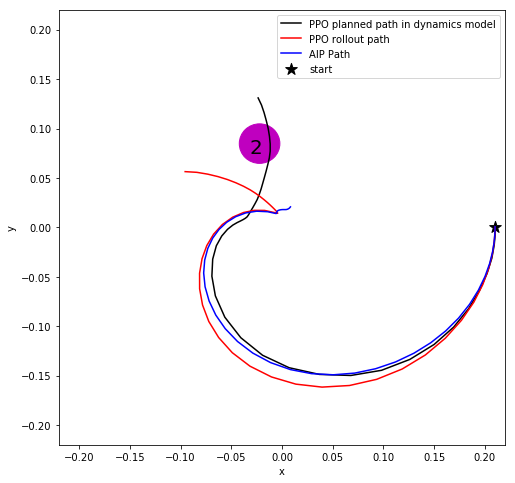

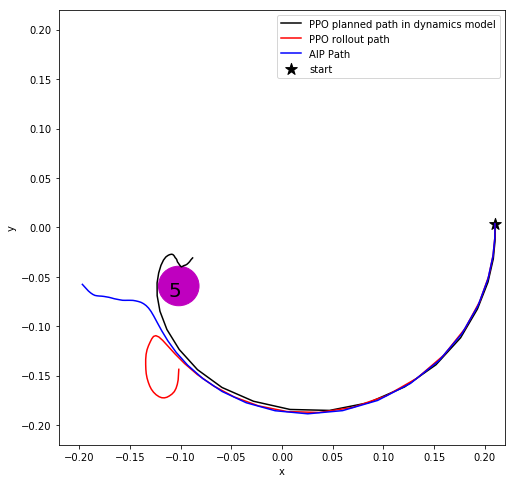

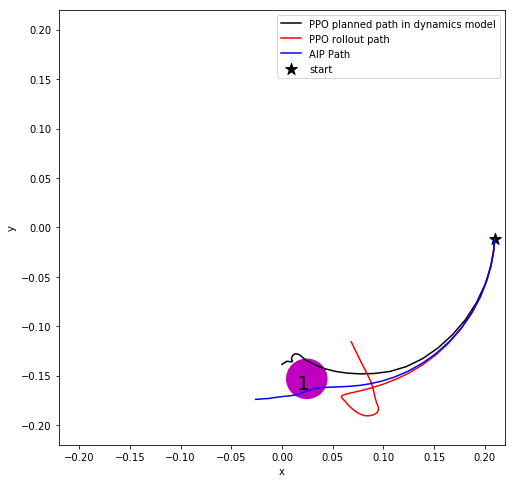

In [3]:
#for seed in range(7,8):
seed=7
load_path='./ppo2_results/models_bkup/corl_Reacher-v2/seed_'+str(seed)
if ho!=0:
    load_path='./ppo2_results/models_bkup/corl_Reacher-v2/seed_ho'+str(ho)+'_'+str(seed)
model,runner=prepare(env_id,seed,load_path,model,goal_height=1.0,ho=ho)

from r_diff.model_config import get_make_mlp_model
from r_diff.r_diff import R_diff_model
from common.input import observation_placeholder
env_aip=build_env('Reacher-v2',0,1.0,ho=0.999,ah_goal_loc_idx=8,ctrl_rwd=1,env_type='mujoco')
ob_space = env_aip.observation_space
ac_space = env_aip.action_space
policy_aip = build_policy_aip(env_aip, 'mlp', value_network='copy')
make_model = get_make_mlp_model(num_fc=2, num_fwd_hidden=500, layer_norm=False)
r_diff_model = R_diff_model(env=env_aip, env_id='Reacher-v2', make_model=make_model,update_epochs=5,  batch_size=512)
ob = observation_placeholder(ob_space,name='Ob')
ref_ac = observation_placeholder(ac_space,name='Ref_ac')
alpha_holder=tf.placeholder(shape=(None,1), dtype=np.float32, name='Alpha')
with tf.variable_scope("pi_aip"):
    aip_pi=policy_aip(ablation='auto',env_type='mujoco',env_id='Reacher-v2',ref_type='ppo',policy_ref=model,r_diff_model=r_diff_model,alpha_func='squared',observ_placeholder=ob,ac_placeholder=ref_ac,alpha_placeholder=alpha_holder)
aip_pi.load('./icra_results/reacher_models/AIP_alpha_auto_seed_0')

#for run_idx in [1,2,5]:
for run_idx in [2,5,1]:
    obs, returns, masks, actions, values, neglogpacs, states, epinfos, final_obs, succ, best_eps_ret, best_eps_len = runner.run(env_type='corl',do_eval=True,num_eval_eps=1,compare=True,compare_ah_idx=run_idx,reacher_sd=run_idx,acrobot_sd=run_idx)
    do_eval_epinfobuf=deque(maxlen=100)
    do_eval_epinfobuf.extend(epinfos)
    observ=obs[:do_eval_epinfobuf[0]['l'],:]
    actions=actions[:do_eval_epinfobuf[0]['l'],:]
    observ=np.concatenate([observ,final_obs[0]],axis=0)
    res_folder='./mjo_policy_eval_results/'
    if ho!=0:
        res_folder='./mjo_policy_eval_results_ho'+str(ho)+'/'
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    np.savetxt(res_folder+'Reacher-v2_run'+str(run_idx)+'_traj.txt',observ, fmt='%.20f', delimiter=',')
    np.savetxt(res_folder+'Reacher-v2_run'+str(run_idx)+'_plan.txt',actions, fmt='%.20f', delimiter=',')
    #rollout_reacher(res_folder,run_idx,observ,actions)
    compare_reacher('./icra_results/reacher_plots/',aip_pi,run_idx,observ,actions)


